In [1]:
import numpy as np
from myplotstyle import plt, FIG_WIDTH, legend_ordered

from easyquery import Query, QueryMaker
import SAGA
from SAGA import ObjectCuts as C
from SAGA import HostCuts as H

from SAGA.utils.distance import z2v
from colossus.halo.profile_nfw import NFWProfile
from colossus.cosmology import cosmology
from astropy.table import unique
from astropy.io import ascii

In [2]:
print(SAGA.__version__)
saga = SAGA.QuickStart()

3.0.0
SAGA `shared_dir` set to /home/yymao/Dropbox/Work/SAGA
SAGA `local_dir`  set to /home/yymao/Documents/Work/Data/SAGA


In [3]:
base = H.paper3.filter(saga.object_catalog.load_combined_base_catalog())
nhosts = len(np.unique(base["HOSTID"]))
assert nhosts == 101

In [4]:
base = Query(C.has_spec, C.is_low_z, ~C.is_host).filter(base)
base["dvel"] = z2v(base['SPEC_Z']) - base['HOST_VHOST']
base = Query("dvel >= -800", "dvel <= 800", "RHOST_KPC < 800").filter(base)

base.sort("RHOST_KPC")
base = unique(base, "OBJID")
base.sort(["HOSTID", "OBJID"])

sats, lowz = C.is_sat.split(base)
lowz_in, lowz_out = Query("RHOST_KPC < 300").split(lowz)
del base

In [5]:
cosmology.setCosmology('planck18')
halo = NFWProfile(M=2e12*0.7, c=10, z=0.005, mdef="vir")

In [6]:
vel_dis = ascii.read(format="csv", names=["x", "v", "vh"], data_start=0,
    table="""100, 113.7, 123.4
200, 98.6, 107.4
300, 94.9, 103.0
400, 104.8, 115.0
500, 103.4, 113.3
600, 107.5, 120.3""")

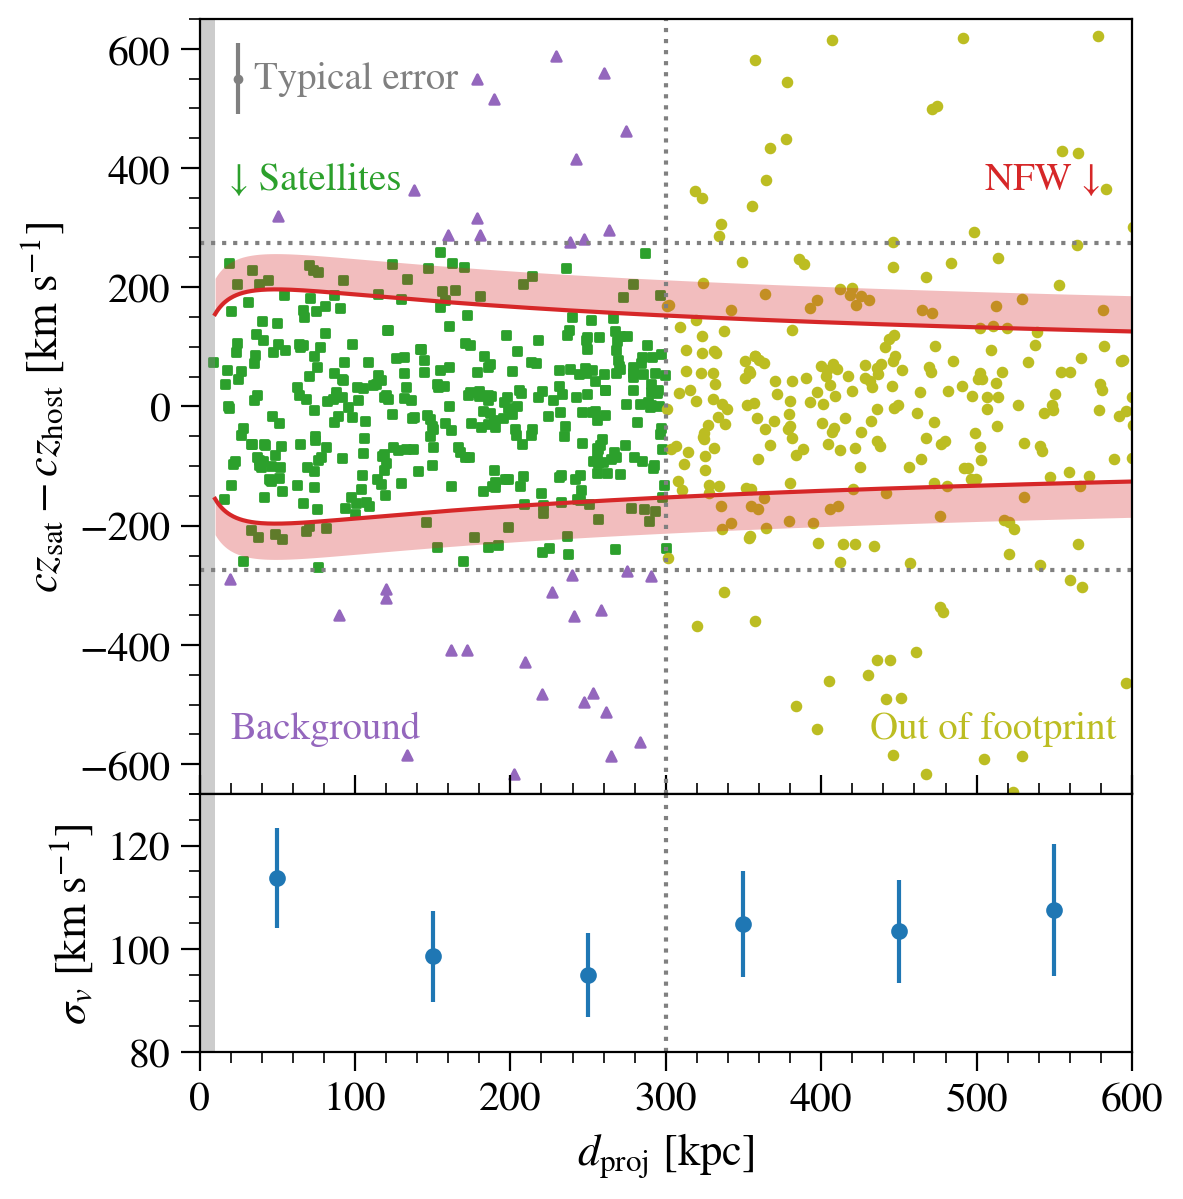

In [7]:
fig, ax_all = plt.subplots(2, 1, figsize=(FIG_WIDTH, FIG_WIDTH), height_ratios=(3,1), sharex=True)
fig.set_constrained_layout_pads(hspace=0, h_pad=0)

ax = ax_all[0]
ax.scatter(sats['RHOST_KPC'], sats['dvel'], c='C2',marker='s',s=10)
ax.scatter(lowz_in['RHOST_KPC'], lowz_in['dvel'], c='C4',marker='^',s=12)
ax.scatter(lowz_out['RHOST_KPC'], lowz_out['dvel'], c="C8",marker='o',s=10)

ax.set_ylim(-650, 650)
ax.set_xlim(0, 600)

ax.axvspan(0, 10, color="grey", alpha=0.4, lw=0)

ax.axvline(300, c="grey", ls=":")
ax.axhline(275, c="grey", ls=":")
ax.axhline(-275, c="grey", ls=":")

ax.set_ylabel(r"$cz_{\rm sat} - cz_{\rm host}$ [km s$^{-1}$]")
ax.tick_params(axis="x", which="both", direction="in")
r = np.linspace(10, 700, 1001)

v_nfw = halo.circularVelocity(r)
ax.fill_between(r, v_nfw, v_nfw+60, color="C3", alpha=0.3, lw=0)
ax.fill_between(r, -v_nfw, -v_nfw-60, color="C3", alpha=0.3, lw=0)
ax.plot(r, v_nfw, color="C3", label=r"NFW, $2 \times 10^{12}{\rm M}_{\odot}$")
ax.plot(r, -v_nfw, color="C3")

ax.errorbar([25], [550], yerr=60, color="grey", marker=".")

ax.text(35, 550, "Typical error", va="center", fontsize=14, color="grey")
ax.text(19, 380, "↓ Satellites", va="center", fontsize=14, color="C2")
ax.text(20, -540, "Background", va="center", fontsize=14, color="C4")
ax.text(590, -540, "Out of footprint", va="center", ha="right", fontsize=14, color="C8")
ax.text(580, 380, "NFW ↓", va="center", ha="right", fontsize=14, color="C3")

ax = ax_all[1]
ax.errorbar(vel_dis["x"]-50, vel_dis["v"], vel_dis["vh"]-vel_dis["v"], marker="o", ls="")
ax.set_ylim(80, 130)
ax.axvspan(0, 10, color="grey", alpha=0.4, lw=0)

ax.set_xlabel(r"$d_{\rm proj}$ [kpc]")
ax.set_ylabel(r"$\sigma_v$ [km s$^{-1}$]")
ax.axvline(300, c="grey", ls=":")

plt.savefig("plots/velocity-dist.pdf")